# Table of Contents
* &nbsp;
	* [0.1 imports](#0.1-imports)
	* [0.2 data](#0.2-data)
* [1. Submitting HITs- metric collection](#1.-Submitting-HITs--metric-collection)
	* [1.1 semantic qualtiy](#1.1-semantic-qualtiy)
	* [1.2 visual quality metric](#1.2-visual-quality-metric)
* [2. Retreive results](#2.-Retreive-results)
	* [2.1 consensus building](#2.1-consensus-building)
		* [2.1.1 code](#2.1.1-code)
		* [2.1.2 run semantic task](#2.1.2-run-semantic-task)
		* [2.1.3 run quality task](#2.1.3-run-quality-task)
	* [2.2 recall](#2.2-recall)
		* [2.2.1 code](#2.2.1-code)
		* [2.2.2 run](#2.2.2-run)
	* [2.3 sanity check](#2.3-sanity-check)
	* [2.4 accept](#2.4-accept)
* [3. investigate quality bins](#3.-investigate-quality-bins)
	* [3.1 review gifs](#3.1-review-gifs)
	* [3.2 optical flow/ direction of motion](#3.2-optical-flow/-direction-of-motion)
		* [3.2.1 experiment](#3.2.1-experiment)
		* [3.2.2 test methods](#3.2.2-test-methods)
		* [3.2.3 classifier](#3.2.3-classifier)
		* [3.2.4 hide](#3.2.4-hide)
* [4. Hide](#4.-Hide)


## 0.1 imports

In [2567]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
from tqdm import tqdm as tqdm
from collections import defaultdict
from collections import Counter

import xmltodict
import cv2
import PIL.Image as pil

import pickle
import boto3
import json
import os
from copy import deepcopy

from IPython.core.display import HTML

from keysTkingdom import mturk_ai2

from mturk.mturk import MTurk

import os
import random
import datetime

%load_ext autoreload
%autoreload 2

In [2]:
%%capture
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
#%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

## 0.2 data

In [ ]:
with open('./data/complete_dataset_3_3.pkl', 'rb') as f:
    complete_ds = pickle.load(f)

missing_pos = [v.gid() for v in complete_ds.data if 'pos_tags' not in  v.data()['parse']]

complete_ds.remove_vids(missing_pos)

In [2732]:
all_fb = !ls ./gen_data/vis_query_test_db_test_stage1_8000_stage2_40000
all_fb = set([f[:28] for f in all_fb if 'mp4' in f])

In [2906]:
with open('test_set_sample_ids.json', 'r') as f:
    sample_400_ids = set(json.load(f))

In [2907]:
sample_test_400 = [v for v in complete_ds.data if v.gid() in sample_400_ids]

### hide

In [2782]:
# sample_ids.to_csv('sample_ids_vis_query_test_db_test_stage1_8000_stage2_40000.csv')

In [2814]:
# data_path  = './gen_data/vis_query_val_db_train_stage1_16000_stage2_28000/'
data_path  = './gen_data/vis_query_test_db_test_stage1_8000_stage2_40000/'
gif_path = './gen_data/new_gifs/'
for f in sample_ids:
    try:
        os.link(data_path + f + '.mp4', gif_path + f + '.mp4')
    except FileExistsError:
        pass

In [2783]:
# descs_sm = [complete_ds.get_video(v).description() for v in easy_val_sm if complete_ds.get_video(v)]

# descs_lg = [complete_ds.get_video(v).description() for v in easy_val_lg_sep if complete_ds.get_video(v)]

# descs_lens_sm = [len(d.split()) for d in descs_sm]
# descs_lens_lg = [len(d.split()) for d in descs_lg]

# # _ = pd.Series(descs_lens_sm).hist()

# len(descs_lens_lg)

In [3]:
# with open('./easy_split_ids.json') as f:
#     split_ids = json.load(f)

# with open('./easy_split_len_hist.json') as f:
#     easy_split_ids = json.load(f)

# easy_split_ids.keys()

# easy_val_sm = split_ids['easy_val_sm']
# easy_val_lg = split_ids['easy_val_lg']

# easy_val_lg_sep = [v for v in easy_val_lg if v not in easy_val_sm]

# len(set(easy_val_lg).intersection(easy_val_sm))

In [12]:
# vid.display_gif()

# 1. Submitting HITs- metric collection

## 1.1 semantic qualtiy

In [2857]:
cat_headers = {
    'entities': 'Are any of the following people/places/things missing from the video?',
    'verbs': 'Do all of the actions highlighted in yellow take place in the video, and are the adjectives true?'
}

verb_blacklist = set(['is', 'are', 'was'])

def gen_template_args_from_datapoint(video, s3_base_path):        
    description = video.description()
    if description[-1] != '.':
        description += '.'
    description = description.replace('\'', '').replace('"', '')
    formatted_description = [[word.encode('utf8').decode() for word in sent.split()] for sent in description.split('.')][:-1]
    
    vid_ents = [[c.data()['labelNPC']] for c in video.data()['characters'] + video.data()['objects']] + [[video.setting()]]
    vid_verbs = [word[0] for word in video.data()['parse']['pos_tags'] if word[1] in ['VBG', 'VBZ', 'VBP', 'JJ'] and word[0] not in verb_blacklist]
    ent_button_js = form_button_arr_js(vid_ents, [v[0] for v in vid_ents], ('entities', cat_headers['entities']))
    verb_button_js = form_button_arr_js(formatted_description, vid_verbs, ('verbs', cat_headers['verbs']))
    
    return {'image_id': video.gid(), 'verb_button_js': verb_button_js, 'ent_button_js': ent_button_js, 's3_base_path': s3_base_path}

def form_button_arr_js(buttons, active, category=None):
    if not buttons:
        return ''
    button_arr_js = f"<br><h4>{category[1]}</h4>"
    for i, sent in enumerate(buttons):
        button_arr_js += '<br>\n'
        for j, word in enumerate(sent):
            b_id = '_'.join(['_'.join(word.split()), str(i), str(j)])
            disabled = '' if word in active else 'disabled=true' 
            color = '#FFFF4C' if word in active else '' 
            button_arr_js += f"<input type='button' onclick=\"record_value('{category[0] + '__' + b_id}');\" value='{word}' id= '{category[0] + '__' + b_id}' {disabled}  style=background-color:{color} />"    
    button_arr_js += f"<br><input type='button' onclick=\"record_value('{category[0] + '__None'}');\" style=background-color:#ff0000 value='None Missing' id='{category[0] + '__None'}' />"
    return button_arr_js

In [2742]:
# pvid = 's_06_e_14_shot_021030_021104'
# pvid = 's_04_e_08_shot_029353_029427'
# pvid = 's_04_e_02_shot_011770_011844'
# sample_vid = 's_06_e_18_shot_006963_007037'
# prob_video = complete_ds.get_video(sample_vid)

In [2817]:
mt_client.preview_hit_interface(template_params, **gen_template_args_from_datapoint(prob_video, client_params['s3_base_path']))

In [2741]:
# demo_vid = deepcopy(prob_video)

# # for char in demo_vid.data()['characters']:
# #     if char.data()['entityLabel'] == 'barney':
# #         char.data()['entityLabel'] = 'wilma'
# # demo_vid.data()['description'] = demo_vid.description().replace('Barney', 'Wilma')

# demo_vid.data()['setting'] = 'kitchen'
# # demo_vid.data()['characters'] = complete_ds.get_video('s_01_e_03_shot_023155_023229').data()['characters']
# # demo_vid.data()['objects'] = complete_ds.get_video('s_01_e_03_shot_023155_023229').data()['objects']
# # demo_vid.data()['parse'] = complete_ds.get_video('s_01_e_03_shot_023155_023229').data()['parse']

# # demo_vid.data()['setting'] = complete_ds.get_video('s_01_e_03_shot_023155_023229').setting()
# demo_vid.data()['description'] = prob_video.description().replace('green', 'blue')

In [39]:
# mt_client.preview_hit_interface(template_params, **gen_template_args_from_datapoint(random.choice(complete_ds.data), client_params['s3_base_path']))

In [2891]:
static_params = {
    'Title': "Identify errors in a short animation",
    'Description': "You will be shown a short animation clip, and asked to identify anything missing or incorrect in a description of the scene",
    'Keywords': 'animation, clicking, images, answer questions',
    'frame_height': 1000,
    'Reward': f'{0.02}',
    'AssignmentDurationInSeconds': 3600 * 1,
    'AutoApprovalDelayInSeconds': 3600 * 24 * 3,
    'LifetimeInSeconds': 3600 * 24 * 1,
    'MaxAssignments': 3,
}

template_params = {
    'template_file': 'task_template_v3.html', 
    'template_dir': 'hit_templates'
}

client_params = {
    'aws_access_key_id': mturk_ai2.access_key,
    'aws_secret_access_key': mturk_ai2.access_secret_key, 
    'profile_name': None,
    'in_sandbox': False,
    'n_threads': 1,
    's3_base_path': s3_base_path_gen,
}
mt_client = MTurk(**client_params)

Account balance is: $500.07


In [2822]:
# video_batch_hard = [vid for vid in complete_ds.data if vid.gid() in easy_val_lg and vid.gid() not in easy_val_sm][:50]
video_batch = [vid for vid in complete_ds.data if vid.gid() in sample_ids.tolist()]

In [2866]:
mt_client.preview_hit_interface(template_params, **gen_template_args_from_datapoint(random.choice(video_batch), client_params['s3_base_path']))

In [2843]:
s3_base_path_gt = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/scene_gifs/'
s3_base_path_gen = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/generated_gifs/'

In [2848]:
static_params['MaxAssignments'] = 3
# static_params['s3_base_path'] = s3_base_path_gen

In [2890]:
_ = mt_client.expected_cost(video_batch + video_batch, basic_hit_params=static_params)

Insufficient funds: will cost $28.80 but only $0.07 available.


In [2908]:
%%time
# created_hits = mt_client.create_hit_group(video_batch, gen_template_args_from_datapoint, basic_hit_params=static_params, template_params=template_params)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 31 µs


In [114]:
gen_hits = mt_client.unpickle_this('./pickled_res/submitted_batch_100_wed_feb_14_15_08_09_2018.pkl')
gen_hits = [h['HIT'] for h in gen_hits if h]

gt_hits = mt_client.unpickle_this('./pickled_res/submitted_batch_100_wed_feb_14_15_40_22_2018.pkl')
gt_hits = [h['HIT'] for h in gt_hits if h]

In [104]:
all_curr_hits = mt_client.get_all_hits()

In [133]:
%%time
mt_client.expire_hits(all_curr_hits)

CPU times: user 47.3 ms, sys: 8.71 ms, total: 56 ms
Wall time: 1.04 s


In [219]:
# %%time
# mt_client.delete_hits(all_curr_hits)

In [77]:
# mt_client.set_hits_reviewing(all_curr_hits)

In [120]:
# mt_client.approve_assignments(assignments)

In [86]:
# mt_client.force_delete_hits(all_curr_hits)

In [1207]:
# test_vid = random.choice(complete_ds.data)

## 1.2 visual quality metric

Inconsistent positions

Inconsistent Scales

Inconsistent Pose

Inconsistent Motions

Flickering

Segmentation bleed

Duplicate characters

In [2152]:
template_params = {
    'template_file': 'task_template_q_metric.html', 
    'template_dir': 'hit_templates'
}

static_params = {
    'Title': "Identify quality issues in a short animation",
    'Description': "You will be shown a short animation clip and asked which of several possible quality issues are present",
    'Keywords': 'animation, clicking, images, quality',
    'frame_height': 1000,
    'Reward': f'{0.02}',
    'AssignmentDurationInSeconds': 3600 * 1,
    'AutoApprovalDelayInSeconds': 3600 * 24 * 3,
    'LifetimeInSeconds': 3600 * 24 * 1,
    'MaxAssignments': 3,
}

client_params = {
    'aws_access_key_id': mturk_ai2.access_key,
    'aws_secret_access_key': mturk_ai2.access_secret_key, 
    'profile_name': None,
    'in_sandbox': False,
    'n_threads': 1,
    's3_base_path': s3_base_path_gen,
}
mt_client = MTurk(**client_params)

Account balance is: $30.76


In [2138]:
cat_headers = {
    'issues': 'Are any of the issues below present in the video?',
}


def gen_template_args_from_datapoint_v2(video, s3_base_path):        
    issue_list = [
        'Floating characters or objects',
        'Inconsistent scale',
        'Characters or objects positioned incorrectly',
        'Character pose is wrong',
        'Background motion inconsistent with characters',
        'Excessive flickering',
        'Halo of background around character',
        'Characters duplicated'
    ]
    
    issue_button_js = form_button_arr_js_v2(sorted(issue_list, key=lambda x: len(x), reverse=True), ('issue_button_js', cat_headers['issues']))    
    return {'image_id': video.gid(), 'issue_button_js': issue_button_js, 's3_base_path': s3_base_path}

def form_button_arr_js_v2(buttons, category=None):
    if not buttons:
        return ''
    button_arr_js = f""
    for i, sent in enumerate(buttons):
        button_arr_js += '<br>\n'
        word = sent
        b_id = '_'.join(['_'.join(word.split()), str(i)])
        button_arr_js += f"<input type='button' onclick=\"record_value('{category[0] + '__' + b_id}');\" value='{word}' id= '{category[0] + '__' + b_id}'/>"
#         button_arr_js += '<br>'
    button_arr_js += "<br>"
    button_arr_js += f"<br><input type='button' onclick=\"record_value('{category[0] + '__None'}');\" style=background-color:#ff0000 value='No Issues' id='{category[0] + '__None'}' />"
    return button_arr_js

In [2153]:
mt_client.preview_hit_interface(template_params, **gen_template_args_from_datapoint_v2(random.choice(video_batch), client_params['s3_base_path']))

In [2122]:
video_batch = [vid for vid in complete_ds.data if vid.gid() in easy_val_sm]

In [2154]:
len(video_batch)

149

In [2124]:
s3_base_path_gt = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/scene_gifs/'
s3_base_path_gen = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/generated_gifs/'

In [2148]:
static_params['MaxAssignments'] = 3

In [2155]:
_ = mt_client.expected_cost(video_batch, basic_hit_params=static_params)

Batch will cost $10.73


In [2157]:
# %%time
# created_hits = mt_client.create_hit_group(video_batch, gen_template_args_from_datapoint_v2, basic_hit_params=static_params, template_params=template_params)

# 2. Retreive results

## 2.1 consensus building

### 2.1.1 code

In [2535]:
# def process_results(results):
#     processed = {}
#     for gid, responses in results.items():
#         category_resp = defaultdict(list)
#         for resp in responses:
#             for word in resp:
#                 category, val = word.split('__')
#                 category_resp[category].append(val)
#         processed[gid] = dict(category_resp)
#     return processed


# def create_res_dfs(processed_results):
#     ref_res = process_results(processed_results)
#     res_df = pd.DataFrame(ref_res).T.fillna('None')
#     no_issues = res_df[res_df['entities'].apply(lambda x: x[0] == 'None') & res_df['verbs'].apply(lambda x: x[0] in ['None', 'N'])]
#     issues = res_df[~res_df.index.isin(no_issues.index)]
#     ent_issues = issues[~issues['entities'].apply(lambda x: x[0] in ['None', 'N'])]
#     verb_issues = issues[~issues['verbs'].apply(lambda x: x[0] in ['None', 'N'])]
#     both_issues = res_df[~res_df.index.isin(no_issues.index.tolist() + ent_issues.index.tolist() + verb_issues.index.tolist())]
#     return no_issues, ent_issues, verb_issues, both_issues


# def create_res_row(gid, hit_res):
#     resp_rows = []
#     for resp in hit_res:
#         words_by_cat = defaultdict(list)
#         for word in resp:
#             cat, w = word.split('__')
#             words_by_cat[cat].append(w)
#         words_by_cat = dict(words_by_cat)
#         words_by_cat['gid'] = gid
#         resp_rows.append(words_by_cat)
#     return resp_rows


# def make_cons_df(hit_res):
#     results_df = pd.DataFrame.from_records([r for res in hit_res.items() for r in create_res_row(*res)])
#     results_df = results_df[['gid', 'entities', 'verbs']]
#     results_df = results_df.fillna('None')
#     results_df['ent_set'] = results_df['entities'].apply(lambda x: set(x))
#     results_df['verb_set'] = results_df['verbs'].apply(lambda x: set(x))
#     grouped_by_vid = results_df.groupby('gid')
#     agged_on_mode = grouped_by_vid.agg(lambda x: st.mode(x))
#     agged_on_mode['mode_count_ents'] = agged_on_mode['ent_set'].apply(lambda x: x[1][0])
#     agged_on_mode['mode_count_verbs'] = agged_on_mode['ent_set'].apply(lambda x: x[1][0])
#     cons_df = agged_on_mode[agged_on_mode['mode_count_ents'].isin([2, 3])]
#     cons_df = cons_df[cons_df['mode_count_verbs'].isin([2, 3])]
#     cons_df['ent_con_res'] = cons_df['ent_set'].apply(lambda x: list(x[0][0]))
#     cons_df['verb_con_res'] = cons_df['verb_set'].apply(lambda x: list(x[0][0]))
#     cons_df_no_errors = cons_df[(cons_df['ent_con_res'].apply(lambda x: x[0]) == 'None') & (cons_df['verb_con_res'].apply(lambda x: x[0]) == 'None')]
#     return cons_df, results_df

### 2.1.2 run semantic task

In [2877]:
def process_results(results):
    processed = {}
    for gid, responses in results.items():
        category_resp = defaultdict(list)
        for resp in responses:
            for word in resp:
                category, val = word.split('__')
                category_resp[category].append(val)
        processed[gid] = dict(category_resp)
    return processed

def create_res_dfs(processed_results):
    ref_res = process_results(processed_results)
    res_df = pd.DataFrame(ref_res).T.fillna('None')
    no_issues = res_df[res_df['entities'].apply(lambda x: x[0] == 'None') & res_df['verbs'].apply(lambda x: x[0] in ['None', 'N'])]
    issues = res_df[~res_df.index.isin(no_issues.index)]
    ent_issues = issues[~issues['entities'].apply(lambda x: x[0] in ['None', 'N'])]
    verb_issues = issues[~issues['verbs'].apply(lambda x: x[0] in ['None', 'N'])]
    both_issues = res_df[~res_df.index.isin(no_issues.index.tolist() + ent_issues.index.tolist() + verb_issues.index.tolist())]
    return no_issues, ent_issues, verb_issues, both_issues

def create_res_row(gid, hit_res):
    resp_rows = []
    for resp in hit_res:
        words_by_cat = defaultdict(list)
        for word in resp:
            cat, w = word.split('__')
            words_by_cat[cat].append(w)
        words_by_cat = dict(words_by_cat)
        words_by_cat['gid'] = gid
        resp_rows.append(words_by_cat)
    return resp_rows

def make_cons_df(hit_res):
    results_df = pd.DataFrame.from_records([r for res in hit_res.items() for r in create_res_row(*res)])
    results_df = results_df[['gid', 'entities', 'verbs']]
    results_df = results_df.fillna('None')
    results_df['ent_set'] = results_df['entities'].apply(lambda x: set(x))
    results_df['verb_set'] = results_df['verbs'].apply(lambda x: set(x))
    grouped_by_vid = results_df.groupby('gid')
    agged_on_mode = grouped_by_vid.agg(lambda x: st.mode(x))
    agged_on_mode['mode_count_ents'] = agged_on_mode['ent_set'].apply(lambda x: x[1][0])
    agged_on_mode['mode_count_verbs'] = agged_on_mode['ent_set'].apply(lambda x: x[1][0])
    cons_df = agged_on_mode[agged_on_mode['mode_count_ents'].isin([2, 3])]
    cons_df = cons_df[cons_df['mode_count_verbs'].isin([2, 3])]
    cons_df['ent_con_res'] = cons_df['ent_set'].apply(lambda x: list(x[0][0]))
    cons_df['verb_con_res'] = cons_df['verb_set'].apply(lambda x: list(x[0][0]))
    cons_df_no_errors = cons_df[(cons_df['ent_con_res'].apply(lambda x: x[0]) == 'None') & (cons_df['verb_con_res'].apply(lambda x: x[0]) == 'None')]
    return cons_df, results_df

In [2897]:
gen_hits = mt_client.unpickle_this('submitted_batch__production_200_tue_mar_6_11_09_33_2018.pkl')
gen_hits = [h['HIT'] for h in gen_hits if h]
latest_gen_res = mt_client.get_and_extract_results(gen_hits)
# latest_gt_res = mt_client.get_and_extract_results(gt_hits)

# gt_results_df =  make_cons_df(latest_gt_res)
# gt_results_df

In [2898]:
%%capture
# gt_cons_df, gt_results_df =  make_cons_df(latest_gt_res)
# gt_cons_fract = gt_cons_df.shape[0] /(gt_results_df.shape[0] / 3)

gen_cons_df, gen_results_df =  make_cons_df(latest_gen_res)
gen_cons_fract = gen_cons_df.shape[0] /(gen_results_df.shape[0] / 3)

print('{0:.3f}'.format(gt_cons_fract))
print('{0:.3f}'.format(gen_cons_fract))

# gt_cons_df['ent_con_res'].apply(lambda x: x[0] == 'None').sum() / gt_cons_df.shape[0]

grouped_by_vid = gen_results_df.groupby('gid')

ents_per_turker = grouped_by_vid['entities'].apply(lambda x: pd.Series(x.values)).unstack()
verbs_per_turker = grouped_by_vid['verbs'].apply(lambda x: pd.Series(x.values)).unstack()

In [ ]:
results_to_rev = pd.concat([ents_per_turker, verbs_per_turker], axis=1)

results_to_rev.columns = ['entities_1', 'entities_2', 'entities_3', 'verbs_1', 'verbs_2', 'verbs_3']

# results_to_rev['gt_vid'] = results_to_rev.index.to_series().apply(lambda x: s3_base_path_gt + x + '.gif')
results_to_rev['gen_vid'] = results_to_rev.index.to_series().apply(lambda x: s3_base_path_gen + x + '.gif')
results_to_rev['description'] = results_to_rev.index.to_series().apply(lambda x: complete_ds.get_video(x).description())

results_to_rev= results_to_rev[['description', 'entities_1', 'entities_2', 'entities_3', 'verbs_1', 'verbs_2', 'verbs_3', 'gt_vid', 'gen_vid']]


gbsm = gen_results_df[['gid', 'issues']].groupby('gid')

def choose_nc_results(responses):
    issue_counts = Counter()
    for r in responses:
        issue_counts.update(r)
    cons_issues = [i[:-2] for i, count in issue_counts.items() if count > 1 and i != 'None']
    if cons_issues:
        return cons_issues
    return []

chosen_cons_issues = gbsm.aggregate(choose_nc_results)

chosen_cons_issues.to_csv('chosen_cons.csv')

In [2899]:
chosen_cons_issues

issues
gid                                                                            
s_01_e_23_shot_003663_003737                             [Excessive_flickering]
s_01_e_23_shot_006308_006382                             [Excessive_flickering]
s_01_e_23_shot_006523_006597                             [Excessive_flickering]
s_01_e_23_shot_007777_007851                   [Floating_characters_or_objects]
s_01_e_23_shot_016467_016541  [Floating_characters_or_objects, Characters_or...
s_01_e_23_shot_017567_017641  [Excessive_flickering, Halo_of_background_arou...
s_01_e_24_shot_005225_005299              [Halo_of_background_around_character]
s_01_e_24_shot_005489_005563                             [Excessive_flickering]
s_01_e_24_shot_005786_005860                             [Excessive_flickering]
s_01_e_24_shot_006631_006705  [Excessive_flickering, Floating_characters_or_...
s_01_e_24_shot_008664_008738                                                 []
s_01_e_24_shot_014331_014405  [Halo_of_background_around_character, Excessiv...
s_01_e_24_shot_019017_019091  [Background_motion_inconsistent_with_character...
s_01_e_24_shot_026114_026188                                                 []
s_01_e_24_shot_027720_027794  [Excessive_flickering, Halo_of_background_arou...
s_01_e_25_shot_003256_003330  [Floating_characters_or_objects, Characters_or...
s_01_e_25_shot_004015_004089  [Excessive_flickering, Floating_characters_or_...
s_01_e_25_shot_005225_005299                                                 []
s_01_e_25_shot_006897_006971  [Excessive_flickering, Character_pose_is_wrong...
s_01_e_25_shot_007733_007807              [Halo_of_background_around_character]
s_01_e_25_shot_009799_009873  [Characters_or_objects_positioned_incorrectly,...
s_01_e_25_shot_010296_010370                             [Excessive_flickering]
s_01_e_25_shot_021294_021368  [Excessive_flickering, Halo_of_background_arou...
s_01_e_25_shot_034943_035017  [Floating_characters_or_objects, Halo_of_backg...
s_01_e_25_shot_036047_036121  [Background_motion_inconsistent_with_character...
s_02_e_27_shot_004429_004503                                                 []
s_02_e_27_shot_008283_008357  [Floating_characters_or_objects, Background_mo...
s_02_e_27_shot_013101_013175  [Floating_characters_or_objects, Characters_or...
s_02_e_27_shot_015301_015375  [Excessive_flickering, Floating_characters_or_...
s_02_e_27_shot_015950_016024  [Excessive_flickering, Halo_of_background_arou...
...                                                                         ...
s_05_e_22_shot_032769_032843                             [Excessive_flickering]
s_05_e_22_shot_041215_041289  [Excessive_flickering, Characters_or_objects_p...
s_05_e_23_shot_004103_004177  [Excessive_flickering, Halo_of_background_arou...
s_05_e_23_shot_004202_004276  [Floating_characters_or_objects, Halo_of_backg...
s_05_e_23_shot_020328_020402  [Excessive_flickering, Floating_characters_or_...
s_05_e_23_shot_029665_029739  [Background_motion_inconsistent_with_character...
s_05_e_23_shot_033999_034073  [Halo_of_background_around_character, Floating...
s_05_e_23_shot_034188_034262  [Excessive_flickering, Floating_characters_or_...
s_06_e_21_shot_001133_001207  [Excessive_flickering, Floating_characters_or_...
s_06_e_21_shot_001208_001282                             [Excessive_flickering]
s_06_e_21_shot_010712_010786                             [Excessive_flickering]
s_06_e_21_shot_011559_011633  [Background_motion_inconsistent_with_character...
s_06_e_21_shot_011649_011723  [Excessive_flickering, Floating_characters_or_...
s_06_e_21_shot_013803_013877     [Characters_or_objects_positioned_incorrectly]
s_06_e_21_shot_015411_015485                                                 []
s_06_e_21_shot_016599_016673   [Background_motion_inconsistent_with_characters]
s_06_e_21_shot_017638_017712  [Excessive_flickering, Characters_duplicated, ...
s_06_e_21_shot_019569_019643  [Characters_or_objects_positioned_incorrect

### 2.1.3 run quality task

In [ ]:
def process_results(results):
    processed = {}
    for gid, responses in results.items():
        category_resp = defaultdict(list)
        for resp in responses:
            for word in resp:
                category, val = word.split('__')
                category_resp[category].append(val)
        processed[gid] = dict(category_resp)
    return processed


def create_res_dfs(processed_results):
    ref_res = process_results(processed_results)
    res_df = pd.DataFrame(ref_res).T.fillna('None')
    no_issues = res_df[res_df['issues'].apply(lambda x: x[0] == 'None') & res_df['verbs'].apply(lambda x: x[0] in ['None', 'N'])]
    issues = res_df[~res_df.index.isin(no_issues.index)]
    ent_issues = issues[~issues['issues'].apply(lambda x: x[0] in ['None', 'N'])]
    return no_issues, ent_issues, verb_issues, both_issues


def create_res_row(gid, hit_res):
    resp_rows = []
    for resp in hit_res:
        words_by_cat = defaultdict(list)
        for word in resp:
            cat, w = word.split('__')
            words_by_cat[cat].append(w)
        words_by_cat = dict(words_by_cat)
        words_by_cat['gid'] = gid
        resp_rows.append(words_by_cat)
    return resp_rows


def make_cons_df(hit_res):
    results_df = pd.DataFrame.from_records([r for res in hit_res.items() for r in create_res_row(*res)])
    results_df = results_df[['gid', 'issue_button_js']]
    results_df.columns = ['gid', 'issues']
    results_df = results_df.fillna('None')
    results_df['ent_set'] = results_df['issues'].apply(lambda x: set(x))
    grouped_by_vid = results_df.groupby('gid')
    agged_on_mode = grouped_by_vid.agg(lambda x: st.mode(x))
    agged_on_mode['mode_count_ents'] = agged_on_mode['ent_set'].apply(lambda x: x[1][0])
    cons_df = agged_on_mode[agged_on_mode['mode_count_ents'].isin([2, 3])]
    cons_df['ent_con_res'] = cons_df['ent_set'].apply(lambda x: list(x[0][0]))
    cons_df_no_errors = cons_df[(cons_df['ent_con_res'].apply(lambda x: x[0]) == 'None')]
    return cons_df, results_df

In [2568]:
gen_hits = mt_client.unpickle_this('./gen_submitted_batch_149_wed_feb_28_10_05_26_2018.pkl')
gen_hits = [h['HIT'] for h in gen_hits if h]

gt_hits = mt_client.unpickle_this('./gt_submitted_batch_149_wed_feb_28_10_03_00_2018.pkl')
gt_hits = [h['HIT'] for h in gt_hits if h]

In [ ]:
gen_hits = mt_client.unpickle_this('submitted_batch__production_200_tue_mar_6_11_09_33_2018.pkl')

latest_gen_res = mt_client.get_and_extract_results(gen_hits)
latest_gt_res = mt_client.get_and_extract_results(gt_hits)

gt_results_df =  make_cons_df(latest_gt_res)

# gt_results_df

In [ ]:
%%capture
gt_cons_df, gt_results_df =  make_cons_df(latest_gt_res)
gt_cons_fract = gt_cons_df.shape[0] /(gt_results_df.shape[0] / 3)

gen_cons_df, gen_results_df =  make_cons_df(latest_gen_res)
gen_cons_fract = gen_cons_df.shape[0] /(gen_results_df.shape[0] / 3)

print('{0:.3f}'.format(gt_cons_fract))
print('{0:.3f}'.format(gen_cons_fract))

gt_cons_df['ent_con_res'].apply(lambda x: x[0] == 'None').sum() / gt_cons_df.shape[0]

grouped_by_vid = gen_results_df.groupby('gid')

ents_per_turker = grouped_by_vid['issues'].apply(lambda x: pd.Series(x.values)).unstack()
# ents_per_turker = grouped_by_vid['ents'].apply(lambda x: pd.Series(x.values)).unstack()
# verbs_per_turker = grouped_by_vid['verbs'].apply(lambda x: pd.Series(x.values)).unstack()

In [2872]:
results_to_rev = pd.concat([ents_per_turker], axis=1)
# results_to_rev = pd.concat([ents_per_turker, verbs_per_turker], axis=1)

# results_to_rev.columns = ['entities_1', 'entities_2', 'entities_3', 'verbs_1', 'verbs_2', 'verbs_3']
results_to_rev.columns = ['issues_1', 'issues_2', 'issues_3']

results_to_rev['gt_vid'] = results_to_rev.index.to_series().apply(lambda x: s3_base_path_gt + x + '.gif')
results_to_rev['gen_vid'] = results_to_rev.index.to_series().apply(lambda x: s3_base_path_gen + x + '.gif')
results_to_rev['description'] = results_to_rev.index.to_series().apply(lambda x: complete_ds.get_video(x).description())

# results_to_rev= results_to_rev[['description', 'entities_1', 'entities_2', 'entities_3', 'verbs_1', 'verbs_2', 'verbs_3', 'gt_vid', 'gen_vid']]
results_to_rev= results_to_rev[['description', 'issues_1', 'issues_2', 'issues_3', 'gt_vid', 'gen_vid']]

results_to_rev.to_csv('qual_gt_rev1.csv')

sm_df = gen_results_df.head(6)

gbsm = gen_results_df[['gid', 'issues']].groupby('gid')

def choose_nc_results(responses):
    issue_counts = Counter()
    for r in responses:
        issue_counts.update(r)
    cons_issues = [i[:-2] for i, count in issue_counts.items() if count > 1 and i != 'None']
    if cons_issues:
        return cons_issues
    return []

chosen_cons_issues = gbsm.aggregate(choose_nc_results)

chosen_cons_issues.to_csv('chosen_cons.csv')

## 2.2 recall

### 2.2.1 code

In [2885]:
def get_word_pos_tag(word, video):
    pos_tags = video.data()['parse']['pos_tags']
    for sent_word, tag in pos_tags:
        if sent_word.lower() == word.lower():
            return tag
    return ''

def possible_per_category(video):
    per_category = Counter()
    per_category['entities'] =  len(video.data()['characters']) + len(video.data()['objects'])
    per_category['verbs'] = len([word[0] for word in video.data()['parse']['pos_tags'] if word[1] in ['VBG', 'VBZ', 'VBP'] and word[0] not in verb_blacklist])
    per_category['adjectives'] = len([word[0] for word in video.data()['parse']['pos_tags'] if word[1] in ['JJ'] and word[0]])
    return per_category

def count_errors(gid, hit_res):
    video = complete_ds.get_video(gid)
    reponses_by_cat = defaultdict(list)
    for resp in hit_res:
        for word in resp:
            cat, w_span = word.split('__')
            if w_span == 'None':
                continue
            w, start, stop = w_span.rsplit('_', maxsplit=2)
            word_pos = get_word_pos_tag(w, video)
            if word_pos == 'JJ':
                cat = 'adjectives'
            reponses_by_cat[cat].append(w)
#     print(reponses_by_cat)
    response_cat_counts = {k: Counter(v) for k, v in reponses_by_cat.items()}
    possible_per_cat = possible_per_category(video)
    flaws_by_cat = defaultdict(list)
    for cat, counts in response_cat_counts.items():
        for word, count in counts.items():
            if count > 1 and word != 'None':
                flaws_by_cat[cat].append(word)
    recall_per_cat = {cat: [len(flaws_by_cat[cat]), possible_per_cat[cat]] for cat in possible_per_cat.keys()}
    return gid, recall_per_cat

def compute_recall(agg_counts):
    mistakes = defaultdict(int)
    possible = defaultdict(int)
    for gid, vid in agg_counts:
        for cat, res in vid.items():
            mistakes[cat] += res[0]
            possible[cat] += res[1]
    recalls = {cat: 1- mistakes[cat] / possible[cat] for cat in mistakes.keys() if possible[cat]}
    return recalls

def assign_len_bin(gid):
    bins = {
        'bin_0_10': [0, 10],
        'bin_10_20': [10, 20],
        'bin_20_20_plus': [20, np.Inf]
    }
    video = complete_ds.get_video(gid)
    desc_len = len(video.description().split())
    return [b for b, (lower, upper) in bins.items() if lower < desc_len <= upper].pop()

def report_by_bin(count_mistakes):
    mistakes_by_bin = defaultdict(list)
    for gid, vid in count_mistakes:
        mistakes_by_bin[assign_len_bin(gid)].append((gid, vid))

    for b, vids in mistakes_by_bin.items():
        print(b)
        print({k: '{0:.3f}'.format(v) for k, v in compute_recall(vids).items()})
        print()
    return mistakes_by_bin

### 2.2.2 run

In [2882]:
latest_gen_res = mt_client.get_and_extract_results(gen_hits)
# latest_gt_res = mt_client.get_and_extract_results(gt_hits)

In [2883]:
# count_mistakes_gt = [count_errors(*hit) for hit in latest_gt_res.items()]
# recall_gt = compute_recall(count_mistakes_gt)

In [2886]:
count_mistakes_gen = [count_errors(*hit) for hit in latest_gen_res.items()]
recall_gen = compute_recall(count_mistakes_gen)

In [2888]:
print({k: '{0:.3f}'.format(v) for k, v in recall_gen.items()})
# print({k: '{0:.3f}'.format(v) for k, v in recall_gt.items()})

{'entities': '0.628', 'verbs': '0.653', 'adjectives': '0.602'}


300 vid sample

In [628]:
print('ground truth')
_ = report_by_bin(count_mistakes_gt)
print()
print('easy val')
_ = report_by_bin(count_mistakes_gen)

ground truth
bin_10_20
{'entities': '0.957', 'verbs': '0.989', 'adjectives': '0.980'}

bin_20_20_plus
{'entities': '1.000', 'verbs': '0.977', 'adjectives': '1.000'}

bin_0_10
{'entities': '0.987', 'verbs': '0.984', 'adjectives': '1.000'}


easy val
bin_10_20
{'entities': '0.559', 'verbs': '0.642', 'adjectives': '0.529'}

bin_20_20_plus
{'entities': '0.457', 'verbs': '0.535', 'adjectives': '0.538'}

bin_0_10
{'entities': '0.803', 'verbs': '0.694', 'adjectives': '0.375'}



1. Noun, Adj, Action Recall (averaged across videos)

2. Bin by description  length 0-10, 10-20, 20-30
3. Noun, Adj, Action Accuracy
4. 2 for accuracy
200 sentences our dataset
200 for templated sentences
5. Filter out sentences where 3 turkers agree

## 2.3 sanity check

In [189]:
gt_no_issues, gt_ent_issues, gt_verb_issues, gt_both_issues = create_res_dfs(latest_gt_res)
val_no_issues, val_ent_issues, val_verb_issues, val_both_issues = create_res_dfs(latest_gen_res)

In [190]:
print(gt_no_issues.shape[0])
print(gt_ent_issues['entities'].apply(lambda x: len(x)).sum())
print(gt_verb_issues['verbs'].apply(lambda x: len(x)).sum())

90
7
2


In [191]:
print(val_no_issues.shape[0])
print(val_ent_issues['entities'].apply(lambda x: len(x)).sum())
print(val_verb_issues['verbs'].apply(lambda x: len(x)).sum())

75
21
13


here are some results:
    
I ran 100 videos, 50 from sm and 50 from lg

for both the generated and gt videos

for gt: 89% no errors, 
10 total entity errors (wrong char or object), 6 total verb errors

for val: 75% no errors
21 total entity errors (wrong char or object), 17 total verb errors

In [163]:
from IPython.display import Image

In [165]:
s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/generated_gifs/'
def display_gif_generated(video):
    gif_url = s3_base_path + video.gid() + '.gif'
    return Image(url=gif_url)

In [225]:
gt_ent_issues[gt_ent_issues.index == vid_id].iloc[0]

entities    [room_1_0]
verbs             None
Name: s_06_e_22_shot_029687_029761, dtype: object

In [241]:
gt_verb_issues

entities           verbs
s_03_e_25_shot_016784_016858   [None]      [lays_0_1]
s_06_e_21_shot_001133_001207   [None]  [sneezing_0_3]

In [245]:
vid_id = random.choice(gt_verb_issues.index)
# vid_id = 's_05_e_23_shot_004103_004177'
pvid = complete_ds.get_video(vid_id)

print(pvid.description())
print(gt_verb_issues[gt_verb_issues.index == vid_id].iloc[0])
pvid.display_gif()
# display_gif_generated(pvid)

Mr Slate is sneezing outside. 
entities            [None]
verbs       [sneezing_0_3]
Name: s_06_e_21_shot_001133_001207, dtype: object


## 2.4 accept

In [209]:
latest_gen_asgmts = mt_client.get_all_assignments(gen_hits)

In [210]:
latest_gt_asgmts = mt_client.get_all_assignments(gt_hits)

In [211]:
complete_as = [a for a in latest_gen_asgmts if a['Assignments']]

In [212]:
len(complete_as)

149

In [217]:
# for hit in complete_as:
#     for assignment in hit['Assignments']:
#         print(assignment['AssignmentStatus'])

In [213]:
mt_client.approve_assignments(complete_as)

# 3. investigate quality bins

## 3.1 review gifs

In [63]:
import jinja2
from IPython.display import Image

In [64]:
display_gifs_template = """{% for vid in vids %}
<img src="https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/generated_gifs/{{vid}}.gif" height=300 width=400>
<h3>{{vid}}</h3>
{% endfor %}
"""

In [65]:
template = jinja2.Environment(loader=jinja2.BaseLoader).from_string(display_gifs_template)
page_html = template.render(vids=easy_val_lg)

In [66]:
with open('rev_gen_gifs.html', 'w') as f:
    f.write(page_html)

In [84]:
# somvid.description()

## 3.2 optical flow/ direction of motion

### 3.2.1 experiment

In [465]:
# feature_params = dict( maxCorners = 100,
#                        qualityLevel = 0.3,
#                        minDistance = 7,
#                        blockSize = 7 )

# # Parameters for lucas kanade optical flow
# lk_params = dict( winSize  = (15,15),
#                   maxLevel = 2,
#                   criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# # Create some random colors
# color = np.random.randint(0,255,(100,3))

# # Take first frame and find corners in it
# test_vid = cv2.VideoCapture ('./gen_data/vis_query_val_db_train_stage1_16000_stage2_28000/' + svid_id + '.mp4')

# vid_frame_data = []
# while(test_vid.isOpened()):
#     ret, frame = test_vid.read()
#     if ret == True:
#         vid_frame_data.append(frame)
#     else:
#         break
# vid_frame_data = np.array(vid_frame_data)

# old_gray = cv2.cvtColor(vid_frame_data[0], cv2.COLOR_BGR2GRAY)
# p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

# # Create a mask image for drawing purposes
# mask = np.zeros_like(vid_frame_data[0])
# drawn_frames = []
# for i in range(1, vid_frame_data.shape[0]):
#     frame = vid_frame_data[i]
#     frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#     # calculate optical flow
#     p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

#     # Select good points
#     good_new = p1[st==1]
#     good_old = p0[st==1]

#     # draw the tracks
#     for i,(new,old) in enumerate(zip(good_new,good_old)):
#         a,b = new.ravel()
#         c,d = old.ravel()
#         mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
#         frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
#     img = cv2.add(frame,mask)
#     drawn_frames.append(img)
#     # Now update the previous frame and previous points
#     old_gray = frame_gray.copy()
#     p0 = good_new.reshape(-1,1,2)
# flow_frames_img = [pil.fromarray(f) for f in drawn_frames]
# flow_frames_img[0].save('flow_viz.gif', save_all=True, optimize=False, duration=42, append_images=flow_frames_img[1:])
# ! mogrify -loop 0  *.gif

# Image(filename='./flow_viz.gif')

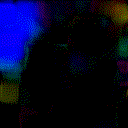

In [972]:
# svid_id = 's_05_e_22_shot_000407_000481'
# svid_id = 's_02_e_28_shot_003949_004023'
# svid_id = 's_04_e_22_shot_015906_015980'
# svid_id = 's_05_e_22_shot_003146_003220'
svid_id = 's_04_e_22_shot_015906_015980'


somvid = complete_ds.get_video(svid_id)

farneback_params={
        'pyr_scale':0.5,
        'levels':15,
        'winsize':15,
        'iterations': 3,
        'poly_n': 5,
        'poly_sigma':1.2,
        'flags':0
    }

test_vid = cv2.VideoCapture ('./gen_data/vis_query_val_db_train_stage1_16000_stage2_28000/' + svid_id + '.mp4')

vid_frame_data = []
while(test_vid.isOpened()):
    ret, frame = test_vid.read()
    if ret == True:
        vid_frame_data.append(frame)
    else:
        break
vid_frame_data = np.array(vid_frame_data)

angular_vals = []
mag_vals = []
flow_frames = []
hsv = np.zeros_like(vid_frame_data[0])
hsv[...,1] = 255

prvs = cv2.cvtColor(vid_frame_data[0], cv2.COLOR_BGR2GRAY)
next = cv2.cvtColor(vid_frame_data[1], cv2.COLOR_BGR2GRAY)
flow = cv2.calcOpticalFlowFarneback(prvs, next, None, **farneback_params)
farneback_params['flags'] = cv2.OPTFLOW_USE_INITIAL_FLOW
for i in range(2, vid_frame_data.shape[0]):
    prvs = cv2.cvtColor(vid_frame_data[i - 1], cv2.COLOR_BGR2GRAY)
    next = cv2.cvtColor(vid_frame_data[i], cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prvs, next, flow, **farneback_params)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    angular_vals.append(hsv[...,0])
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255 ,cv2.NORM_MINMAX)
    mag_vals.append(hsv[...,2])
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    flow_frames.append(rgb)

flow_frames_img = [pil.fromarray(f) for f in flow_frames]
flow_frames_img[0].save('flow_viz.gif', save_all=True, optimize=False, duration=42, append_images=flow_frames_img[1:])
! mogrify -loop 0  *.gif

Image(filename='./flow_viz.gif')

In [973]:
avg_angles_cv = np.array(angular_vals).mean(axis=0)
avg_mag_cv = np.array(mag_vals).mean(axis=0)
above_thresh = avg_mag_cv > 50
print(avg_angles_cv[above_thresh].mean())
np.median(avg_angles_cv[above_thresh])

57.41702127659575


47.0

In [ ]:
avg_angles_1 = hsv_1.mean(axis=0)[:, : , 0]
avg_mag_1 = hsv_1.mean(axis=0)[:, :, 2]
above_thresh = avg_mag_1 > 50
print(avg_angles_1[above_thresh].mean())
np.median(avg_angles_1[above_thresh])

In [645]:
from pyflow import pyflow

In [646]:
import time

In [895]:
def dense_flow(vid_frame_data):
    alpha = 0.012
    ratio = 0.75
    minWidth = 20
    nOuterFPIterations = 7
    nInnerFPIterations = 1
    nSORIterations = 30
    colType = 0  # 0 or default:RGB, 1:GRAY (but pass gray image with shape (h,w,1))

    hsv = np.zeros_like(vid_frame_data[0])
    hsv[...,1] = 255
    angular_vals = []
    flow_frames = []
    hsv_frames = []

    for i in tqdm(range(1, vid_frame_data.shape[0], 2)):   
        im1 = vid_frame_data[i - 1]
        im2 = vid_frame_data[i]
        im1 = im1.astype(float) / 255.
        im2 = im2.astype(float) / 255.
        u, v, im2W = pyflow.coarse2fine_flow(
            im1, im2, alpha, ratio, minWidth, nOuterFPIterations, nInnerFPIterations,
            nSORIterations, colType)
        mag, ang = cv2.cartToPolar(u, v)
        hsv[..., 0] = ang * 180 / np.pi
        hsv[..., 2] = cv2.normalize(mag, None, 0, 255 ,cv2.NORM_MINMAX)
        angular_vals.append(hsv[...,0])
        rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
        flow_frames.append(rgb)
        hsv_frames.append(hsv)
    return  flow_frames, np.array(hsv_frames)

In [927]:
# svid_id = 's_04_e_22_shot_015906_015980'
svid_id = 's_05_e_22_shot_003146_003220'
svid_frame_data = get_frame_arr_data(svid_id)
flow_frames, hsv_1 = dense_flow(svid_frame_data)

100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


In [928]:
avg_angles_1 = hsv_1.mean(axis=0)[:, : , 0]
avg_mag_1 = hsv_1.mean(axis=0)[:, :, 2]
above_thresh = avg_mag_1 > 50
print(avg_angles_1[above_thresh].mean())
np.median(avg_angles_1[above_thresh])

30.606562311860326


5.0

In [929]:
# _ = pd.Series(avg_mag_1.flatten()).hist(bins=30)

In [930]:
# _ = pd.Series(avg_angles_1[above_thresh].flatten()).hist(bins=30)

bg moving to right:

77, 66

30, 5

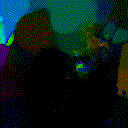

In [901]:
flow_frames_img = [pil.fromarray(f) for f in flow_frames]
flow_frames_img[0].save('flow_viz.gif', save_all=True, optimize=False, duration=42, append_images=flow_frames_img[1:])
! mogrify -loop 0  *.gif
Image(filename='./flow_viz.gif')

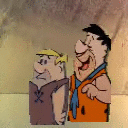

In [1098]:
svid_id = 's_04_e_22_shot_015906_015980'
Image(filename='./gen_data/new_gifs/' + svid_id + '.gif')

In [810]:
# _ = pd.Series(hsv_stat.mean(axis=0)[:, :, 2].flatten()).hist(bins=100)

In [947]:
# svid_id = 's_05_e_22_shot_000407_000481'
svid_id = 's_01_e_23_shot_007777_007851'
# svdid_id = 's_02_e_27_shot_025927_026001'
# svid_id = 's_03_e_24_shot_005575_005649'
svid_frame_data = get_frame_arr_data(svid_id)
flow_frames, hsv_2 = dense_flow(svid_frame_data)

100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


In [948]:
avg_angles_2 = hsv_2.mean(axis=0)[:, : , 0]
avg_mag_2 = hsv_2.mean(axis=0)[:, :, 2]
above_thresh = avg_mag_2 > 50
print(avg_angles_2[above_thresh].mean())
np.median(avg_angles_2[above_thresh])

157.50599149594123


101.0

bg moving to left:


144, 140

157, 101

157, 101

164, 178

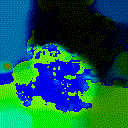

In [839]:
flow_frames_img = [pil.fromarray(f) for f in flow_frames]
flow_frames_img[0].save('flow_viz.gif', save_all=True, optimize=False, duration=42, append_images=flow_frames_img[1:])
! mogrify -loop 0  *.gif
Image(filename='./flow_viz.gif')

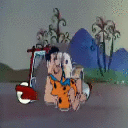

In [840]:
Image(filename='./gen_data/new_gifs/' + svid_id + '.gif')

In [842]:
# svid_id = 's_05_e_22_shot_000407_000481'
# # svid_id = 's_02_e_28_shot_003949_004023'
# # svid_id = 's_04_e_22_shot_015906_015980'
# somvid = complete_ds.get_video(svid_id)

# test_vid = cv2.VideoCapture ('./gen_data/vis_query_val_db_train_stage1_16000_stage2_28000/' + svid_id + '.mp4')

# vid_frame_data = []
# while(test_vid.isOpened()):
#     ret, frame = test_vid.read()
#     if ret == True:
#         vid_frame_data.append(frame)
#     else:
#         break
# vid_frame_data = np.array(vid_frame_data)
# angular_vals = []
# flow_frames = []
# hsv = np.zeros_like(vid_frame_data[0])
# hsv[...,1] = 255
# for i in range(1, vid_frame_data.shape[0]):
#     prvs = cv2.cvtColor(vid_frame_data[i - 1], cv2.COLOR_BGR2GRAY)
#     next = cv2.cvtColor(vid_frame_data[i], cv2.COLOR_BGR2GRAY)
#     flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

#     mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
#     angular_vals.append(hsv[...,0])
#     hsv[...,0] = ang * 180 / np.pi / 2
#     hsv[...,2] = cv2.normalize(mag, None, 0, 255 ,cv2.NORM_MINMAX)
#     rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
#     flow_frames.append(rgb)

# flow_frames_img = [pil.fromarray(f) for f in flow_frames]
# flow_frames_img[0].save('flow_viz.gif', save_all=True, optimize=False, duration=42, append_images=flow_frames_img[1:])
# ! mogrify -loop 0  *.gif

# Image(filename='./flow_viz.gif')

In [843]:
# Image(filename='./gen_data/new_gifs/' + svid_id + '.gif')

In [443]:
av_arr = np.array(angular_vals)

In [ ]:
os.lis

In [446]:
av_arr.mean()

90.84613037109375

improve

background motion - match direction of motion to source video

get raw_output_arrays

### 3.2.2 test methods

In [2115]:
def get_frame_arr_data_gen(svid_id):
    somvid = complete_ds.get_video(svid_id)

    test_vid = cv2.VideoCapture ('./gen_data/vis_query_val_db_train_stage1_16000_stage2_28000/' + svid_id + '.mp4')

    vid_frame_data = []
    while(test_vid.isOpened()):
        ret, frame = test_vid.read()
        if ret == True:
            vid_frame_data.append(frame)
        else:
            break
    svid_frame_data = np.array(vid_frame_data)
    return svid_frame_data

def get_frame_arr_data(vid):
    t_dir = 'trajectories'
    frame_arr_dir = 'frame_arr_data'
    if not type(vid) == str:
        vid = vid.gid()
    return np.load(os.path.join(t_dir, frame_arr_dir, vid  + '.npy'))

def dense_flow(vid_frame_data):
    alpha = 0.012
    ratio = 0.75
    minWidth = 20
    nOuterFPIterations = 7
    nInnerFPIterations = 1
    nSORIterations = 30
    colType = 0  # 0 or default:RGB, 1:GRAY (but pass gray image with shape (h,w,1))

    hsv = np.zeros_like(vid_frame_data[0])
    hsv[...,1] = 255
    angular_vals = []
    flow_frames = []
    hsv_frames = []

    for i in range(1, vid_frame_data.shape[0], 2):   
        im1 = vid_frame_data[i - 1]
        im2 = vid_frame_data[i]
        im1 = im1.astype(float) / 255.
        im2 = im2.astype(float) / 255.
        u, v, im2W = pyflow.coarse2fine_flow(
            im1, im2, alpha, ratio, minWidth, nOuterFPIterations, nInnerFPIterations,
            nSORIterations, colType)
        mag, ang = cv2.cartToPolar(u, v)
        hsv[..., 0] = ang * 180 / np.pi
        hsv[..., 2] = cv2.normalize(mag, None, 0, 255 ,cv2.NORM_MINMAX)
        angular_vals.append(hsv[...,0])
        rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
        flow_frames.append(rgb)
        hsv_frames.append(hsv)
    return  np.array(hsv_frames), flow_frames

def dense_flow_cv(vid_frame_data):
    farneback_params={
            'pyr_scale':0.5,
            'levels':15,
            'winsize':15,
            'iterations': 3,
            'poly_n': 5,
            'poly_sigma':1.2,
            'flags':0
        }
        
    hsv_frames = []
    flow_frames = []
    hsv = np.zeros_like(vid_frame_data[0])
    hsv[...,1] = 255
    for i in range(1, vid_frame_data.shape[0], 1):
        prvs = cv2.cvtColor(vid_frame_data[i - 1], cv2.COLOR_BGR2GRAY)
        next = cv2.cvtColor(vid_frame_data[i], cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prvs, next, None, **farneback_params)
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        hsv[..., 0] = ang * 180 / np.pi
        hsv[..., 2] = cv2.normalize(mag, None, 0, 255 ,cv2.NORM_MINMAX)
        hsv_frames.append(hsv)
        rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
        flow_frames.append(rgb)
    return np.array(hsv_frames), flow_frames

def viz_optical_flow(o_frame_data):
    flow_frames_img = [pil.fromarray(f) for f in o_frame_data]
    flow_frames_img[0].save('flow_viz.gif', save_all=True, optimize=False, duration=42, append_images=flow_frames_img[1:])
    ! mogrify -loop 0  *.gif
    return Image(filename='./flow_viz.gif')

In [1084]:
# print(classify_dom(vid_hsv))
# print(classify_dom(alt_hsv))

In [1064]:
moving_bgs = pd.read_csv('moving_bg.txt', header=None, names=['vid'])
moving_bgs['vid'] = moving_bgs['vid'].apply(lambda x: x.split('_bg')[0])

In [1104]:
# svid_id = 's_04_e_22_shot_015906_015980'
# fa_data = get_frame_arr_data_gen(svid_id)
# Image(filename='./gen_data/new_gifs/' + svid_id + '.gif')

In [1117]:
test_vid

's_06_e_12_shot_014298_014372'

In [1182]:
from collections import OrderedDict

In [1385]:
label_dom = OrderedDict(filtered_labels)

In [1533]:
test_vid = random.choice(moving_bgs['vid'])
if test_vid in label_dom:
    print('seen')
print(test_vid)
fvideo = complete_ds.get_video(test_vid)
fa_data = get_frame_arr_data(test_vid)
label_dom[test_vid] = ''
fvideo.display_gif()

s_03_e_01_shot_017325_017399


In [1526]:
label_dom[test_vid] = 'leftward'
filtered_labels = {k: v for k, v in label_dom.items() if v}
len(filtered_labels)

98

In [1534]:
label_dom[test_vid] = 'rightward'
filtered_labels = {k: v for k, v in label_dom.items() if v}
len(filtered_labels)

100

In [1535]:
filtered_labels = {k: v for k, v in label_dom.items() if v}
len(filtered_labels)

100

In [1576]:
pd.Series(list(filtered_labels.values())).value_counts()

leftward     51
rightward    49
dtype: int64

In [1537]:
with open('hand_labeled_dom2.pkl', 'wb') as f:
    pickle.dump(filtered_labels, f)

In [1173]:
vid_hsv, rgb_frames = dense_flow(fa_data)

100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


In [1587]:
print('\npyflow: '+ classify_dom(vid_hsv), '     opencv: ' + classify_dom(alt_hsv))


pyflow: rightward      opencv: leftward


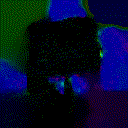

In [1176]:
viz_optical_flow(rgb_frames)

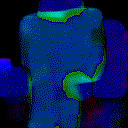

In [1177]:
viz_optical_flow(alt_rgb_frames)

In [2192]:
pred_correct = {}
for vid, gt in tqdm(list(filtered_labels.items())[:30]):
    try:
        fa_data = get_frame_arr_data(vid)
        alt_hsv, alt_rgb_frames = dense_flow_cv(fa_data)
        pred = classify_dom(alt_hsv, magnitude_thresh=10, direction_thresh=127)
        pred_correct[vid] = pred == gt
        if not pred == gt:
            print(vid, gt)
    except:
        print('err')
        
cv_acc = sum(pred_correct.values()) / len(pred_correct)
cv_acc

  3%|▎         | 1/30 [00:00<00:10,  2.86it/s]

6575
4870
168.46899383983572


  7%|▋         | 2/30 [00:00<00:09,  2.97it/s]

7567
3801
84.75848460931334


 10%|█         | 3/30 [00:01<00:09,  2.99it/s]

4139
910
89.72307692307692


 13%|█▎        | 4/30 [00:01<00:08,  3.02it/s]

5620
3780
81.18571428571428


 17%|█▋        | 5/30 [00:01<00:08,  3.05it/s]

1798
1182
111.30710659898477
s_04_e_12_shot_024156_024230 leftward


 20%|██        | 6/30 [00:01<00:07,  3.02it/s]

7189
3494
83.14224384659416
s_05_e_10_shot_039633_039707 leftward


 23%|██▎       | 7/30 [00:02<00:07,  3.02it/s]

9064
2480
98.89153225806452


 27%|██▋       | 8/30 [00:02<00:07,  3.03it/s]

8652
2398
127.7393661384487
s_05_e_10_shot_018612_018686 rightward


 30%|███       | 9/30 [00:02<00:06,  3.07it/s]

7424
6308
101.7584020291693
s_03_e_19_shot_017743_017817 leftward


 33%|███▎      | 10/30 [00:03<00:06,  3.09it/s]

7797
1882
120.40701381509032


 37%|███▋      | 11/30 [00:03<00:06,  3.11it/s]

4545
387
69.53488372093024


 40%|████      | 12/30 [00:03<00:05,  3.12it/s]

7612
2821
123.80822403403049
s_02_e_02_shot_041963_042037 leftward


 43%|████▎     | 13/30 [00:04<00:05,  3.10it/s]

10701
3357
150.11945189156987


 47%|████▋     | 14/30 [00:04<00:05,  3.07it/s]

7726
2109
140.78757705073494


 50%|█████     | 15/30 [00:04<00:04,  3.05it/s]

8324
5025
105.48318407960198
s_01_e_13_shot_007029_007103 leftward


 53%|█████▎    | 16/30 [00:05<00:04,  3.04it/s]

7913
4314
127.4573481687529


 57%|█████▋    | 17/30 [00:05<00:04,  3.06it/s]

8208
7213
137.74740052682657


 60%|██████    | 18/30 [00:05<00:03,  3.07it/s]

4672
2164
70.92375231053605


 63%|██████▎   | 19/30 [00:06<00:03,  3.08it/s]

5962
1077
158.4076137418756


 67%|██████▋   | 20/30 [00:06<00:03,  3.07it/s]

8349
3454
155.328025477707


 70%|███████   | 21/30 [00:06<00:02,  3.07it/s]

2110
996
68.49698795180723


 73%|███████▎  | 22/30 [00:07<00:02,  3.05it/s]

7781
330
140.34242424242424
s_05_e_03_shot_042768_042842 rightward


 77%|███████▋  | 23/30 [00:07<00:02,  3.04it/s]

6047
2373
74.30257058575643


 80%|████████  | 24/30 [00:07<00:01,  3.02it/s]

7958
2982
91.3065057008719


 83%|████████▎ | 25/30 [00:08<00:01,  3.02it/s]

4360
1803
129.18746533555185
s_06_e_19_shot_028411_028485 rightward


 87%|████████▋ | 26/30 [00:08<00:01,  3.02it/s]

7243
3260
153.5687116564417


 90%|█████████ | 27/30 [00:08<00:00,  3.01it/s]

2266
1013
71.08588351431392


 93%|█████████▎| 28/30 [00:09<00:00,  3.01it/s]

6250
3319
178.45586019885508


 97%|█████████▋| 29/30 [00:09<00:00,  3.01it/s]

8242
2571
121.82185919875535
s_02_e_25_shot_003828_003902 leftward


100%|██████████| 30/30 [00:09<00:00,  3.02it/s]

9805
2291
150.42034046268006
s_03_e_22_shot_019567_019641 rightward


0.6666666666666666

In [2193]:
pred_errors_dir = {}
for vid, gt in tqdm(list(filtered_labels.items())[:30]):
    if not pred_correct[vid]:
        pred_errors_dir[vid] = gt

100%|██████████| 30/30 [00:00<00:00, 159479.24it/s]


In [2194]:
pd.Series(list(pred_errors_dir.values())).value_counts()

leftward     6
rightward    4
dtype: int64

In [2195]:
pred_errors_dir

{'s_01_e_13_shot_007029_007103': 'leftward',
 's_02_e_02_shot_041963_042037': 'leftward',
 's_02_e_25_shot_003828_003902': 'leftward',
 's_03_e_19_shot_017743_017817': 'leftward',
 's_03_e_22_shot_019567_019641': 'rightward',
 's_04_e_12_shot_024156_024230': 'leftward',
 's_05_e_03_shot_042768_042842': 'rightward',
 's_05_e_10_shot_018612_018686': 'rightward',
 's_05_e_10_shot_039633_039707': 'leftward',
 's_06_e_19_shot_028411_028485': 'rightward'}

In [2113]:
def dense_flow_cv(vid_frame_data, farneback_params=None):
    if not farneback_params:
        farneback_params={
                'pyr_scale':0.5,
                'levels':15,
                'winsize':15,
                'iterations': 3,
                'poly_n': 10,
                'poly_sigma':1.2,
                'flags':0
            }
    hsv_frames = []
    flow_frames = []
    hsv = np.zeros_like(vid_frame_data[0])
    hsv[..., 1] = 255
    for i in range(1, vid_frame_data.shape[0], 1):
        prvs = cv2.cvtColor(vid_frame_data[i - 1], cv2.COLOR_BGR2GRAY)
        next = cv2.cvtColor(vid_frame_data[i], cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prvs, next, None, **farneback_params)
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        hsv[..., 0] = ang * 180 / np.pi
        hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        hsv_frames.append(hsv)
        rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
        flow_frames.append(rgb)
    return np.array(hsv_frames), flow_frames

In [1920]:
farneback_params={
        'pyr_scale':0.5,
        'levels':15,
        'winsize':15,
        'iterations': 3,
        'poly_n': 5,
        'poly_sigma':1.2,
        'flags': 0
}

alt_hsv, alt_rgb_frames = dense_flow_cv(fa_data, farneback_params)

In [2184]:
255 / 360 * 180

127.5

In [2482]:
classify_dom(alt_hsv, magnitude_thresh=0, direction_thresh=110)

'rightward'

In [2197]:
inc_vid = complete_ds.get_video('s_03_e_22_shot_019567_019641')
inc_vid = complete_ds.get_video('s_01_e_13_shot_007029_007103')
fa_data = get_frame_arr_data(inc_vid)
inc_vid.display_gif()

In [2198]:
alt_hsv, alt_rgb_frames = dense_flow_cv(fa_data)

In [2221]:
avg_x1 = alt_hsv.mean(axis=0)

In [2222]:
avg_x1.shape

(128, 128, 3)

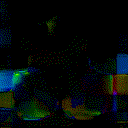

In [2199]:
viz_optical_flow(alt_rgb_frames)

In [2209]:
classify_dom(alt_hsv, magnitude_thresh=10, direction_thresh=125)

8324
5025
105.48318407960198


'rightward'

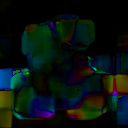

In [2200]:
avg_vis = alt_hsv.mean(axis=0)
avg_rgb = cv2.cvtColor(avg_vis.astype(np.uint8),cv2.COLOR_HSV2BGR)
pil.fromarray(avg_rgb)

In [2002]:
# avg_vis[:, : , 0].mean()

experiments

opencv mean at=100:

0.69

opencv median at=100:

0.68

opencv mean at=180:

0.49

opencv mean at=110:

0.7

opencv mean at=120:

0.68

opencv mean at=80:

0.68

In [2493]:
pyflow_pred_correct = {}
hsv_frames = {}
for vid, gt in tqdm(list(filtered_labels.items())):
    try:
        fa_data = get_frame_arr_data(vid)
        vid_hsv, rgb_frames = dense_flow(fa_data)
        pred = classify_dom(vid_hsv, direction_thresh=100)
        pyflow_pred_correct[vid] = pred == gt
        hsv_frames[vid] = vid_hsv
    except:
        print('err')
        
pyflow_acc = sum(pyflow_pred_correct.values()) / len(pyflow_pred_correct)

 58%|█████▊    | 58/100 [10:38<07:42, 11.01s/it]/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 100/100 [17:57<00:00, 10.77s/it]


In [2495]:
pyflow_acc

0.69

In [2505]:
with open('pflow_hsv_frames.pkl', 'rb') as f:
    pyflow_res = pickle.load(f)

In [ ]:
def classify_dom(video_hsv, magnitude_thresh = 50, direction_thresh = 100):
    avg_angle = video_hsv.mean(axis=0)[:, : , 0]
    avg_mag = video_hsv.mean(axis=0)[:, :, 2]
#     avg_angle = np.median(video_hsv, axis=0)[:, : , 0]
#     avg_mag = np.median(video_hsv, axis=0)[:, :, 2]

    above_thresh = avg_mag > magnitude_thresh
#     leftw = np.logical_and(avg_angle > 32, avg_angle < 95)
#     rightw = np.logical_and(avg_angle > 160, avg_angle < 216)
    leftw = np.logical_and(avg_angle > 32, avg_angle < 95)
    rightw = np.logical_and(avg_angle > 160, avg_angle < 216)
    angle_condition = np.logical_or(leftw, rightw)
#     print(angle_condition.sum())
    condition = np.logical_and(above_thresh, angle_condition)
#     print(condition.sum())
    angle_mean = avg_angle[condition].mean()
#     angle_mean = avg_angle[above_thresh].mean()
    angle_median = np.median(avg_angle[condition])
#     print(angle_median)
    if angle_median < direction_thresh:
        return 'rightward'
    else:
        return 'leftward'

In [2529]:
pyflow_pred_correct = {}
for vid, gt in tqdm(list(filtered_labels.items())):
    vid_hsv = pyflow_res[vid]
    pred = classify_dom(vid_hsv, direction_thresh=100, magnitude_thresh=0)
    pyflow_pred_correct[vid] = pred == gt
        
pyflow_acc = sum(pyflow_pred_correct.values()) / len(pyflow_pred_correct)

100%|██████████| 100/100 [00:00<00:00, 260.62it/s]


0.73

### 3.2.3 classifier

In [2224]:
import sklearn.preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import sklearn.metrics
from scipy.stats import ttest_ind
#X_train, X_test, y_train, y_test =train_test_split(x,y, test_size = 0.20, random_state = 4)

In [2226]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC

In [2234]:
labels = np.array(sorted(list(filtered_labels.items())))

In [2240]:
labels[:, 0]

's_01_e_01_shot_033462_033536'

In [2252]:
X_train = np.array([dense_flow_cv(get_frame_arr_data(str(vid)))[0].mean(axis=0)[:, :, 0].flatten() for vid in labels[:, 0][:10]])

In [2249]:
Y_train = labels[:, 1][:10]

In [2254]:
X_train.shape

(10, 16384)

In [2227]:
dom_cls = SVC()

In [2256]:
dom_cls.fit(X_train, Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [2259]:
dom_cls.predict(X_train[1:2])

array(['leftward'], dtype='<U28')

### 3.2.4 hide

In [ ]:
cap = cv2.VideoCapture("vtest.avi")

ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255

In [23]:
# while(1):
#     ret, frame2 = cap.read()
#     next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

#     flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

#     mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
#     hsv[...,0] = ang * 180/np.pi/2
#     hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
#     rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

#     cv2.imshow('frame2',rgb)
#     k = cv2.waitKey(30) & 0xff
#     if k == 27:
#         break
#     elif k == ord('s'):
#         cv2.imwrite('opticalfb.png',frame2)
#         cv2.imwrite('opticalhsv.png',rgb)
#     prvs = next

# cap.release()
# cv2.destroyAllWindows()

# 4. Hide

In [ ]:
# def gen_template_args_from_datapoint_v1(video):
#     description = video.description()
#     if description[-1] != '.':
#         description += '.'
#     description = description.replace('\'', '')
#     formatted_description = [[word.encode('utf8').decode() for word in sent.split()] for sent in description.split('.')][:-1]
#     return {'image_id': video.gid(), 'formatted_description': formatted_description}


In [ ]:
# test_vid = complete_ds.get_video('s_06_e_13_shot_041125_041199')

# complete_ds.get_video('s_01_e_03_shot_023155_023229').description()

# demo_vid = deepcopy(test_vid)

# # for char in demo_vid.data()['characters']:
# #     if char.data()['entityLabel'] == 'barney':
# #         char.data()['entityLabel'] = 'wilma'
# # demo_vid.data()['description'] = demo_vid.description().replace('Barney', 'Wilma')

# # demo_vid.data()['setting'] = 'kitchen'
# demo_vid.data()['characters'] = complete_ds.get_video('s_01_e_03_shot_023155_023229').data()['characters']
# demo_vid.data()['objects'] = complete_ds.get_video('s_01_e_03_shot_023155_023229').data()['objects']
# demo_vid.data()['parse'] = complete_ds.get_video('s_01_e_03_shot_023155_023229').data()['parse']

# demo_vid.data()['setting'] = complete_ds.get_video('s_01_e_03_shot_023155_023229').setting()
# demo_vid.data()['description'] = complete_ds.get_video('s_01_e_03_shot_023155_023229').description()

In [ ]:
# responses = [mt_client.create_html_hit(basic_hit_params=static_params, template_params=template_params, **gen_template_args_from_datapoint(vid)) for vid in videos]

In [ ]:
# sent_len_threshold = 30
# current_batch_short_sent = {vid: desc for vid, desc in working_corrected.items() if sent_len_threshold > len(desc.split())}
# current_batch_very_long_sent = {vid: desc for vid, desc in working_corrected.items() if sent_len_threshold <= len(desc.split())}